<div style="text-align:left"><img src="zlogo.png" alt="Zillow" width="20%"></div>


<font color='white'>Zacharia Schmitz, *Junior Data Scientist*</font>

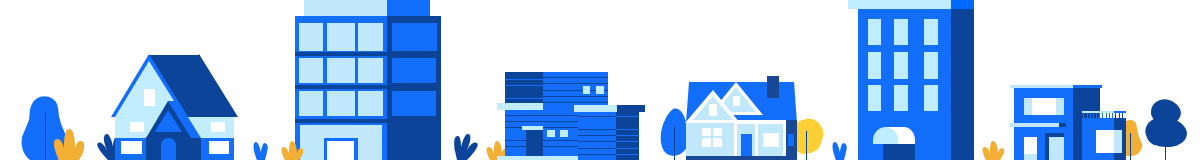

<div style="background-color: #006aff; padding: 10px; color: #18C0C4;">

# <font color='white' size='20'>**Overview**</font>

Predict the tax assessed property value of Zillow Single Family Residential properties with transaction date in 2017.

<div style="background-color: #006aff; padding: 10px; color: #18C0C4;">

# <font color='white' size='20'><i>**Plan**</i></font> → Acquire → Prepare → Explore → Model → Deliver

We started by anticipating what the data would have in it, and developing some ideas that we had about influencers of property value. 

Then once we had the data, we pulled out those features.

<div style="background-color: #006aff; padding: 10px; color: #18C0C4;">

# Plan → <font color='white' size='20'><i>**Acquire**</i></font> → Prepare → Explore → Model → Deliver

* The data is acquired from Codeup's MySQL database on 7 September 2023

* It contained 52,441 rows and 62 columns before processing

* Each row represents a unique home, labeled with a unique `id` provided by Zillow.

* The target value is `taxvaluedollarcnt` which we've renamed to `prop_value`

In [1]:
import wrangle as w
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

In [2]:
# Pull data and verify size

df = w.get_zillow()

Total rows: 52441
Total columns: 62


<div style="background-color: #006aff; padding: 10px; color: #18C0C4;">

# Plan → Acquire → <font color='white' size='20'><i>**Prepare**</i></font> → Explore → Model → Deliver

In [3]:
# Process all of the data to be usable.

df = w.explore_prep_zillow(df)

Final Size
Total rows: 51156
Total columns: 24



### Preparation Summary

1. dropped everything with a significant proportion of null value (> 2% Null), potentially impute with more time **(52,319)**

2. dropped the extreme outliers on property very (upper and lower 1%) **(51,156)**

3. from there, we worked with things we thought would affect `prop_value`

4. we developed `age` by taking 2017 and subtracting the `yearbuilt`
<br>
<br>

| DF Name         |          DB Name              | dtype | Definition                  |
| --------------- | ----------------------------- | ----- | --------------------------- | 
| `age`           | NA *(2017 - `yearbuilt`)*     | int   | Age of the property         |
| `beds`          | `bedroomcnt`                  | int   | Total bedrooms              |
| `baths`         | `bathroomcnt`                 | int   | Total bathrooms             |
| `area`          | `calculatedfinishedsquarefeet`| int   | Square footage of building  |
| `prop_value`    | `taxvaluedollarcnt`           | int   | Tax value of property (USD) |
| `county`        | `fips`                        | str   | County of California        |
| `latitude`      | `latitude`                    | float | Latitude Coordinate         |
| `longitude`     | `longitude`                   | float | Longitude Coordinate        |

<br>

- 06037 = LA County, CA

- 06059 = Orange County, CA

- 06111 = Ventura County, CA

In [4]:
# Set the dataframe to what we'll be exploring

df = df[
    ["baths", "beds", "area", "age", "prop_value", "county", "latitude", "longitude"]
]

In [5]:
# Split into train, validate, test splits

train, val, test = w.split_data(df, random_state=123)

train: 30693 (60% of 51156)
validate: 10231 (20% of 51156)
test: 10232 (20% of 51156)


<div style="background-color: #006aff; padding: 10px; color: #18C0C4;">

# Plan → Acquire → Prepare → <font color='white' size='20'><i>**Explore**</i></font> → Model → Deliver

## Exploration

- Alpha will be set to 0.05 for a confidence of 95%

I chose Spearman's R to assess the strength of a monotonic relationship between non-normally distributed ordinal variables, and I chose the Kruskal-Wallis H test to determine if there were significant differences in medians among multiple groups with non-normally distributed data.

### 1. Is there a correlation between area and property value?

* $H_0$: There is **NO** correlation between `area` and `prop_value`

* $H_a$: There is a correlation between `area` and `prop_value`

* Continuous (`area`) vs Continuous (`prop_value`) = $Spearman's R$
    - $r$ = 0.5076782279486705
    - $p$ = 0.0

**We reject the null hypothesis.**

The p-value is less than alpha. Evidence suggests that `area` and `prop_value` are correlated with each other

Using `area` in modeling should have a positive impact

Spearman's R: area and prop_value
 R = 0.5076782279486705, P = 0.0



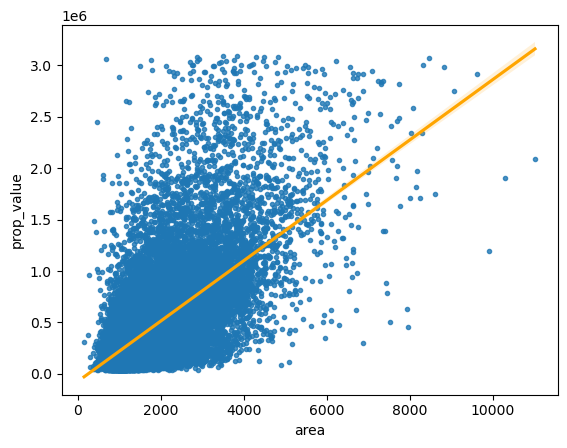

In [6]:
# Test using Spearman R, then plot.

w.spearman(train, "area", "prop_value")

### 2. Is there a correlation between age and property value?

* $H_0$: There is **NO** correlation between age and `prop_value`

* $H_a$: There is a correlation between age and `prop_value`

* Continuous (`age`) vs Continuous (`prop_value`) = $Spearman's R$
    - $r$ = -0.2584091997824955
    - $p$ = 0.0

The p-value is less than alpha. With a negative r-value evidence suggests that `age` and `prop_value` are negatively correlated with each other

Using `age` in modeling should add value

Spearman's R: age and prop_value
 R = -0.2584091997824955, P = 0.0



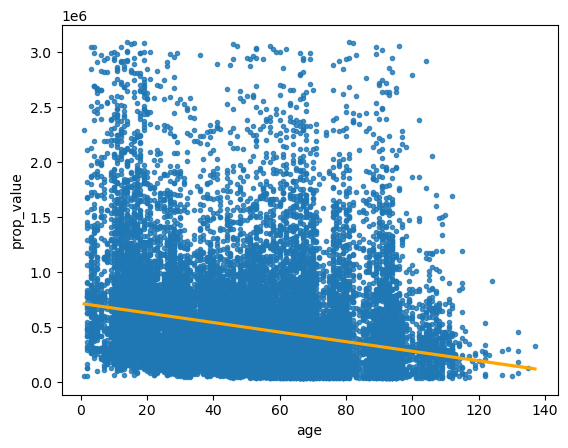

In [7]:
# Test using Spearman R, then plot.

w.spearman(train, "age", "prop_value")

### 3. Is there a correlation between baths and property value?

* $H_0$: There is **NO** correlation between `baths` and `prop_value`

* $H_a$: There is a correlation between `baths` and `prop_value`

* Continuous (`baths`) vs Continuous (`prop_value`) = $Spearman's R$
    - $r$ = 0.46269586819165437
    - $p$ = 0.0

The p-value is less than alpha. Evidence suggests that `baths` and `prop_value` are correlated with each other

Using `baths` in modeling should increase accuracy

Spearman's R: baths and prop_value
 R = 0.46269586819165437, P = 0.0



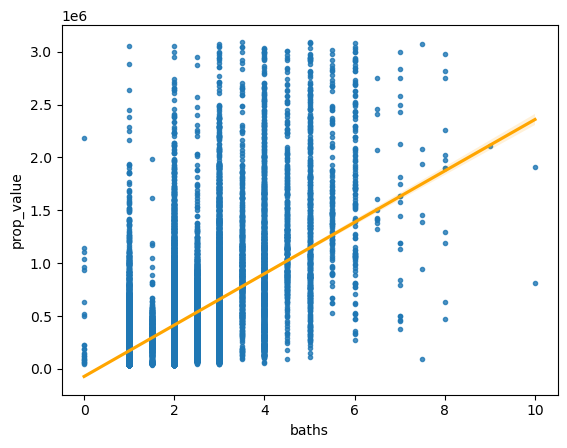

In [8]:
# Test using Spearman R, then plot.

w.spearman(train, "baths", "prop_value")

### 4. Is there a difference in average property value based on county?

* $H_0$: There is **NO** difference in `prop_value`

* $H_a$: There is a difference in `prop_value`

* Discrete (`county`) vs Continuous (`prop_value`) = $Kruskal$-$Wallis$ $H$
    - $H$ statistic = 1122.2740145413604 *(degree of difference)*
    - $p$ = 2.0012168486441073e-244
    
There is a difference in `prop_value` based on `county`

Kruskal-Wallis H-Test:
 stat = 1043.8728842970488, p = 2.117791840364786e-227


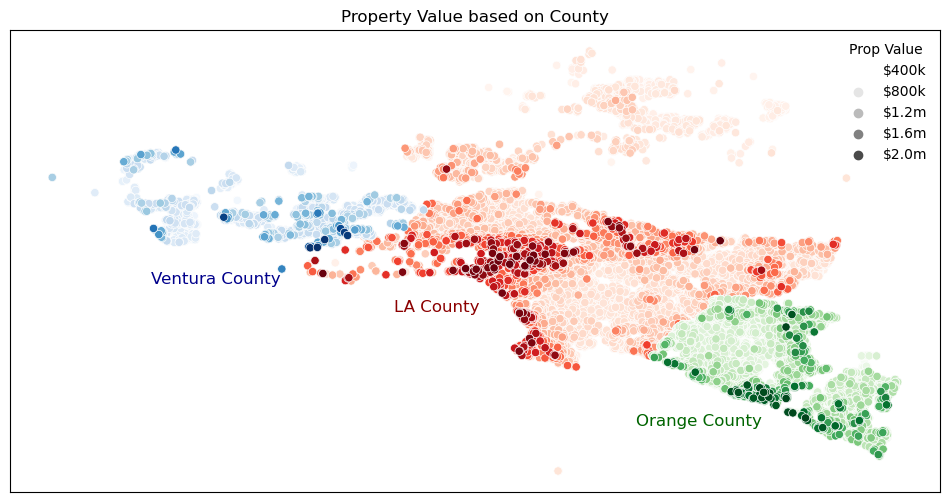

In [9]:
# Test using Kruskal, then plot.

w.plot_property_value_by_county(train)

While the test shows a difference in `prop_value` based on `county`, I believe that it is moreso due to the locations within the county, not the county itself.

We will not include `county`, but will include `latitude` and `longitude`

In [10]:
# Our dataframe moving forward

train = train[["baths", "beds", "area", "age", "prop_value", "latitude", "longitude"]]

<div style="background-color: #006aff; padding: 10px; color: #18C0C4;">

# Plan → Acquire → Prepare → Explore → <font color='white' size='20'><i>**Model**</i></font> → Deliver

In [11]:
# Generate X Splits (dropping targets and county since we aren't using it.)

X_train, X_val, X_test = (
    train.drop(columns=["prop_value"]),
    val.drop(columns=["prop_value"]),
    test.drop(columns=["prop_value"]),
)

# Generate Y Splits (only the target)

y_train, y_val, y_test = (
    train[["prop_value"]],
    val[["prop_value"]],
    test[["prop_value"]],
)

# Establish Baseline with mean

y_train.mean()

prop_value    483036.26019
dtype: float64

### MinMaxScaler performed the best for our models out of Standard, Robust, and MinMax

In [12]:
# Define the columns to be scaled
scale = ["baths", "beds", "area", "age", "latitude", "longitude"]

# Create new DataFrames of scaled data
X_train_mm, X_val_mm, X_test_mm = w.mm_zillow(X_train, X_val, X_test, scale)

### To test our models we used the `itertools` module in our `reg_mods` function to generate all possible combinations of hyperparameters and features for testing the models

In [13]:
# Run models through itertools function (2:30 runtime)

metrics_mm_scale = w.reg_mods(
    X_train_mm,
    y_train,
    X_val_mm,
    y_val,
    alpha=[1, 2, 3, 4, 5, 6, 7, 8, 9],
    degree=[2, 3, 4, 5],
    power=[1, 1.25, 1.5, 1.75, 2],
)

In [14]:
# Temporarily increase column size for viewing
pd.set_option("display.max_colwidth", None)

# A look at the top 10
metrics_mm_scale.sort_values("r2_v", ascending=False).head(10)

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
3670,PolynomialFeature,"[baths_mm, beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",degree=3,310552.807989,311670.551521,0.493307,0.472164
2629,PolynomialFeature,"[area_mm, age_mm, latitude_mm, longitude_mm]",degree=5,301823.571458,311843.644523,0.521392,0.471578
2628,PolynomialFeature,"[area_mm, age_mm, latitude_mm, longitude_mm]",degree=4,312118.450811,312734.125130,0.488186,0.468556
3382,PolynomialFeature,"[baths_mm, area_mm, age_mm, latitude_mm, longitude_mm]",degree=3,314599.736832,312866.613667,0.480016,0.468105
2627,PolynomialFeature,"[area_mm, age_mm, latitude_mm, longitude_mm]",degree=3,316795.169111,313850.217207,0.472733,0.464756
1515,PolynomialFeature,"[area_mm, latitude_mm, longitude_mm]",degree=5,313606.236079,313872.274601,0.483295,0.464680
3383,PolynomialFeature,"[baths_mm, area_mm, age_mm, latitude_mm, longitude_mm]",degree=4,309539.079146,314215.902735,0.496610,0.463508
3386,PolynomialFeature,"[beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",degree=3,313811.432850,314693.369848,0.482618,0.461876
3671,PolynomialFeature,"[baths_mm, beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",degree=4,305287.140174,316052.501418,0.510344,0.457218
3669,PolynomialFeature,"[baths_mm, beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",degree=2,319294.020537,316447.788748,0.464382,0.455859


In [15]:
# Top 3 where model == LassoLars

metrics_mm_scale[metrics_mm_scale.model == "LassoLars"].sort_values(
    "r2_v", ascending=False
).head(3)

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
3668,LassoLars,"[baths_mm, beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",alpha=9,329285.691243,324868.290209,0.430335,0.426515
3667,LassoLars,"[baths_mm, beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",alpha=8,329285.665962,324868.943131,0.430335,0.426513
3666,LassoLars,"[baths_mm, beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",alpha=7,329285.643654,324869.599020,0.430335,0.426511


In [16]:
# Top 3 where model == LinearRegression

metrics_mm_scale[metrics_mm_scale.model == "LinearRegression"].sort_values(
    "r2_v", ascending=False
).head(3)

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
3659,LinearRegression,"[baths_mm, beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",None,329285.570783,324874.273313,0.430336,0.426494
3307,LinearRegression,"[baths_mm, beds_mm, area_mm, latitude_mm, longitude_mm]",None,329778.289683,325750.436620,0.428630,0.423397
3310,LinearRegression,"[beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]",None,332063.996888,327672.851378,0.420682,0.416571


In [17]:
# Top 3 where model == TweedieRegressor

metrics_mm_scale[metrics_mm_scale.model == "TweedieRegressor"].sort_values(
    "r2_v", ascending=False
).head(3)

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
3685,TweedieRegressor,"[baths_mm, beds_mm, area_mm, age_mm, latitude_mm, longitude_mm]","power=1.5,alpha=3",344153.979632,336331.326482,0.377729,0.385330
3581,TweedieRegressor,"[baths_mm, area_mm, age_mm, latitude_mm, longitude_mm]","power=1.5,alpha=3",344363.649405,336453.360417,0.376971,0.384884
3491,TweedieRegressor,"[baths_mm, beds_mm, area_mm, latitude_mm, longitude_mm]","power=1.5,alpha=3",344860.645848,336606.674898,0.375171,0.384323


In [18]:
# Set display back to default
pd.set_option("display.max_colwidth", 20)

## Best Model

In [19]:
# Features
features = ["baths_mm", "beds_mm", "area_mm", "age_mm", "latitude_mm", "longitude_mm"]

# Test a polynomial feature regression model using the specified features and targets.
w.poly_test_model(X_train_mm, y_train, X_test_mm, y_test, features=features, degree=3)

Polynomial Features through Linear Regression
Test    RMSE: 326009.2105731276    R2: 0.47378331923867467


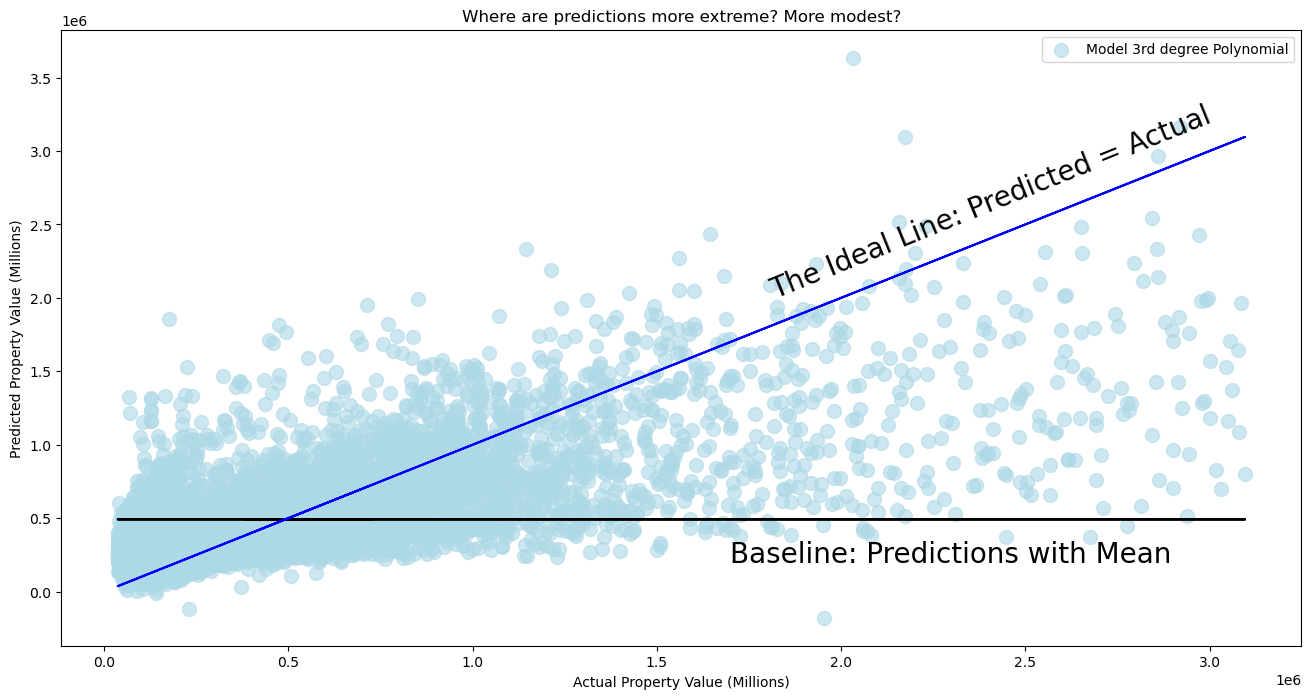

In [20]:
# Plot the baseline, and the estimates for test model

w.plot_predicted_vs_actual(X_train_mm, y_train, X_test_mm, y_test)

### Modeling Wrap Up

* Polynomial Features had the best performance for train and validate by a significant amount.

* With the test done on Polynomial, we get RMSE 326k and an R2 0.47

<div style="background-color: #006aff; padding: 10px; color: #18C0C4;">

# Plan → Acquire → Prepare → Explore → Model → <font color='white' size='20'><i>**Deliver**</i></font>

## Conclusion

### Takeaways and Key Findings
* There is a correlation between each feature (`area`, `beds`, `baths`, and seemingly the `latitude` and `longitude`) with `prop_value`

### Recommendations
* Rather than comparing all 3 counties at the same time, it would be best to do them individually, due to the huge outliers within LA count.

### Next Steps
* Given more time I could check each county at an individual level and develop models that would be best fit for each county to better predict valuation